In [1]:
import pandas as pd
import tensorflow as tf
import dataset_ops
import numpy as np  # noqa
import matplotlib.pyplot as plt  # noqa
from model_helper import make_model
from metrics import F1, Precision, Recall, soft_dice_loss, remove_clutter_one_sample, ClassPrecision, ClassRecall
import datetime
import cuda
import pandas_format  # noqa
from pathlib import Path
try:
    from tqdm import notebook as tqdm
except ImportError:
    tqdm = None

%matplotlib inline
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

cuda.initialize()

inputs = ('SpeedFts', 'Pitch', 'Roll', 'Yaw', 'current_altitude', )
outputs= ('elev', 'ai', 'rdr', 'throttle', 'Flaps')

mp_dataset_manager = dataset_ops.MicroPilotTestsManager(dataset_dir=Path('h5'), runs_filename='runs.hdf')
mp_all_runs = mp_dataset_manager.get_all_available_tests()

mp_selected_runs = mp_all_runs.loc[(mp_all_runs['Test Length'] > 200) & (mp_all_runs['Test Length'] < 20000)]

Initialized PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import transfer_learning
def create_prec_recall_f1(tolerance):
    prec = Precision(name=f'prec_{tolerance}', tolerance=tolerance)
    recl = Recall(name=f'recall_{tolerance}', tolerance=tolerance)

    return [
        # ClassPrecision(),
        # ClassRecall(),
        prec,
        recl,
        F1(prec, recl),
    ]

evaluation_metrics = create_prec_recall_f1(5) # + create_prec_recall_f1(15) + create_prec_recall_f1(5)

_, mp_train_dataset, mp_test_dataset, mp_validation_dataset = dataset_ops.load_and_split(
    mp_dataset_manager, mp_selected_runs, inputs+outputs, batch_size=25,
    split_ratio=(18, 1, 1), max_length=18000
)
print(mp_train_dataset.element_spec)

Loading data...


done
({'signals': TensorSpec(shape=(None, 18000, 10), dtype=tf.float32, name=None), 'mask': TensorSpec(shape=(None, 18000, 1), dtype=tf.float32, name=None)}, TensorSpec(shape=(None, 18000, 25), dtype=tf.float32, name=None))


## First, train mp model


In [3]:
optimizer = tf.keras.optimizers.Adam(lr=3e-5)

# MP:
mp_model_params = dict(
    inputs=inputs, outputs=outputs,
    input_length=18000,
    n_states=mp_dataset_manager.count_states(),
    convs=[(64, 3), (64, 5), (64, 10), (64, 15), (64, 20)],
    grus=[128, 128],
    skip_denses=0
)

model = make_model(**mp_model_params)
model.compile(loss=soft_dice_loss, optimizer=optimizer, metrics=evaluation_metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signals (InputLayer)            [(None, 18000, 10)]  0                                            
__________________________________________________________________________________________________
mask (InputLayer)               [(None, 18000, 1)]   0                                            
__________________________________________________________________________________________________
mask_stealing_layer (MaskSteali (None, 18000, 10)    0           signals[0][0]                    
                                                                 mask[0][0]                       
__________________________________________________________________________________________________
conv_3 (Conv1D)                 (None, 18000, 64)    1984        mask_stealing_layer[0][0]    

In [4]:
# load_model = 'models/paparazzi-20200810-163206-500.h5'
# load_model = 'models/paparazzi-paparazzi-20200812-184311-500.h5'
# load_model = 'models/paparazzi-paparazzi-20200812-184311-500.h5'
load_model = 'models/TL-20200820-211542-500.h5'
# load_model = None
if load_model:
    model.load_weights(load_model)
else:
    epochs = 500
    # epochs = 5

    training_start_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir="logs/fit/" + training_start_time
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = model.fit(mp_train_dataset,
                        epochs=epochs,
                        validation_data=mp_validation_dataset,
                        callbacks=[
                            tensorboard_callback,
                            # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
                            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                        ])
    model.save(f'models/TL-{training_start_time}-{epochs}.h5')
    # tf.keras.utils.plot_model(model, show_shapes=True, to_file=f'models/paparazzi-{training_start_time}-{epochs}.png')
    # history.history

In [5]:
mp_evaluation = transfer_learning.evaluate_model(model, mp_validation_dataset)
mp_evaluation

prec_5            0.59
recall_5          0.76
prec_15           0.72
recall_15         0.89
prec_25           0.81
recall_25         0.93
class_precision   0.88
class_recall      0.95
dtype: float16

## Now do some Paparazzi

In [6]:
pp_optimizer = tf.keras.optimizers.Adam(lr=3e-4)
pp_dataset_manager = dataset_ops.PaparazziTestManager(dataset_dir=Path('pprz_h5'), runs_filename='pprz_runs.hdf')
pp_selected_runs = pp_dataset_manager.get_all_available_tests().sample(frac=1, axis=1)#, random_state=55)
_, pp_train_dataset, pp_test_dataset, pp_validation_dataset = dataset_ops.load_and_split(
    pp_dataset_manager, pp_selected_runs, inputs+outputs, batch_size=25,
    split_ratio=(10, 1, 2), max_length=18000
)
pp_train_dataset: tf.data.Dataset
pp_test_dataset: tf.data.Dataset
pp_validation_dataset: tf.data.Dataset
print(pp_train_dataset.element_spec)

Loading data...


done
({'signals': TensorSpec(shape=(None, 18000, 10), dtype=tf.float32, name=None), 'mask': TensorSpec(shape=(None, 18000, 1), dtype=tf.float32, name=None)}, TensorSpec(shape=(None, 18000, 20), dtype=tf.float32, name=None))


In [ ]:
results = dict()
training_histories = dict()

In [ ]:
# model_path = Path('models/transfer_intermediates/freeze_after_16')
model_path = Path('models/transfer_intermediates/')
model_path.mkdir(parents=True, exist_ok=True)
unfreeze_schedule = {
    0: 3,
    # 0: None,
    16: 1
}
if unfreeze_schedule and unfreeze_schedule.get(0, None) is not None:
    layers_set = (unfreeze_schedule[0], )
else:
    layers_set = (1, 3)
    unfreeze_schedule = None

# for X in (5, 10, 15, 20, 25):
# for i, X in enumerate((20, 15, )*10, start=20):
for i, X in enumerate([*range(5, 80,5)]*10, start=380):
    for layers in layers_set:
        if unfreeze_schedule:
            col_name = f'layer_dynamic__x_{X}__trial_{i}'
        else:
            col_name = f'layer_{layers}__x_{X}__trial_{i}'
        if (model_path / (col_name+'.h5')).exists():
            new_model, evaluation_result = transfer_learning.load_model(
                file_name=model_path / (col_name+'.h5'),
                validation_dataset=pp_validation_dataset,
            )
        else:
            # shuffled_training = tf.data.Dataset.from_tensors(pp_train_dataset_concrete)
            new_model, evaluation_result, training_history = transfer_learning.train_and_test_transfer_model(
                X=X,
                optimizer=pp_optimizer,
                training_dataset=pp_train_dataset.shuffle(20*X),
                validation_dataset=pp_validation_dataset,
                loss=soft_dice_loss,
                metrics_=evaluation_metrics,
                plot=False,
                summary=False,
                epochs=30,
                unfreeze_schedule=unfreeze_schedule,
                # model args:
                original_model=model,
                original_model_params=mp_model_params,
                layers_to_drop=layers,
                n_states=pp_dataset_manager.count_states(),
            )
            training_history['layers'] = layers
            training_history['X'] = X
            training_histories[col_name] = training_history

            training_history.to_csv(model_path / (col_name + '_history.csv'))
            new_model.save(model_path / (col_name+'.h5'))

        evaluation_result.rename(col_name, inplace=True)
        evaluation_result['layers'] = layers
        evaluation_result['X'] = X
        results[col_name] = evaluation_result

In [ ]:
results_df = pd.DataFrame(results).T
results_df.loc[results_df.index.str.contains('dynamic'), 'layers'] = 'dynamic'
# results_df.to_hdf('dynamic_results.h5', key='dynamic_results')


In [ ]:
with pandas_format.PandasFloatFormatter('{:,.2f}'):
    # display(pd.concat(results, axis=1).T)
    display(results_df)

In [ ]:
# results_df.groupby(['layers', 'X']).mean()
results_df.groupby(['layers', 'X']).median()
results_df.groupby(['layers', 'X']).median().to_csv('tl_median.csv')

In [ ]:
results_df.sort_values(['layers', 'X']).set_index(['layers', 'X'])

In [ ]:
results_df

In [ ]:
results_df.to_csv(model_path/'summary.csv')
results_df.to_hdf(model_path/'results.h5', 'results')

In [ ]:
# pd.concat(training_histories, keys=[x.name for x in results])
concatenated_histories = pd.concat(training_histories)
for idx in concatenated_histories.index.get_level_values(0).unique():
    concatenated_histories.loc[idx].drop(['X', 'layers'], axis=1).plot()
    plt.title(idx)

In [ ]:
results = dict()
files = [file for file in Path('models/transfer_intermediates/').iterdir()
    if file.suffix == '.h5']

new_model = transfer_learning.prepare_transfer_model(
    original_model=model,
    original_model_params=mp_model_params,
    layers_to_drop=1,
    n_states=pp_dataset_manager.count_states(),
)
new_model.compile(loss=soft_dice_loss, optimizer=pp_optimizer, metrics=evaluation_metrics)

In [ ]:
for file in files:
    colname = file.name[:-3]
    parts = colname.split('_')
    new_model.load_weights(str(file))
    evaluation_results = transfer_learning.evaluate_model(new_model, pp_validation_dataset)
    # new_model, evaluation_results = transfer_learning.load_model(file, pp_validation_dataset)
    results[colname] = evaluation_results
    results[colname]['layers'] = 300 if parts[1] == 'dynamic' else int(parts[1])
    results[colname]['X'] = int(parts[4])

In [ ]:
results


In [ ]:
for file in files:
    colname = file.name[:-3]
    parts = colname.split('_')
    layers = parts[1] if parts[1] == 'dynamic' else int(parts[1])
    X = int(parts[4])
    results[colname] = results[colname].astype('float64')
    results[colname]['layers'] = 300 if parts[1] == 'dynamic' else int(parts[1])
    results[colname]['X'] = int(parts[4])

## Transfer Learning Baseline 1
Training the same architecture and hyper params from scratch

In [ ]:
training_histories, results = dict(), dict()

model_path = Path('models/transfer_baselines/1/')
model_path.mkdir(parents=True, exist_ok=True)

for i, X in enumerate([*range(5, 80, 5)]*10):
    col_name = f'baseline_1__x_{X}__trial_{i}'
    model_file_path = model_path / (col_name+'.h5')
    if model_file_path.exists():
        new_model, evaluation_result = transfer_learning.load_model(
            file_name=model_file_path,
            validation_dataset=pp_validation_dataset,
        )
    else:
        # shuffled_training = tf.data.Dataset.from_tensors(pp_train_dataset_concrete)
        new_model, evaluation_result, training_history = transfer_learning.train_and_test_transfer_model(
            X=X,
            optimizer=pp_optimizer,
            training_dataset=pp_train_dataset.shuffle(20*X),
            validation_dataset=pp_validation_dataset,
            loss=soft_dice_loss,
            metrics_=evaluation_metrics,
            plot=False,
            summary=False,
            epochs=30,
            unfreeze_schedule=None,
            # model args:
            original_model=model,
            original_model_params=mp_model_params,
            layers_to_drop=-1,
            n_states=pp_dataset_manager.count_states(),
        )
        training_history['X'] = X
        training_histories[col_name] = training_history

        training_history.to_csv(model_path / (col_name + '_history.csv'))
        new_model.save(model_file_path)

    evaluation_result.rename(col_name, inplace=True)
    evaluation_result['X'] = X
    results[col_name] = evaluation_result

In [ ]:
results_df = pd.DataFrame(results).T
results_df.to_hdf(model_path / 'baseline1_results.h5', 'baseline1')
results_df.to_csv(model_path / 'baseline1_results.csv')


In [ ]:
results_df.groupby('X').median().to_csv(model_path / 'baseline1_results_summary.csv')

## Second baseline
Using the same mp model with the same weights without fine-tuning anything on Paparazzi's data

1. Generate the mapping

training dataset size: tf.Tensor(292, shape=(), dtype=int32)
expected output (292, 18000) input_length (292,)
pred 14 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 24]
xout 19 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19]
cont (19, 14) [[    28     56   3038  33630   2784    384     40    708   1141      0
     174    928   1324  24158]
 [   124    182   3653   5636    944      4    126   3536    160      6
      23     60    322     43]
 [    14     18   9476  25893   1557     67     26   1076     85      6
       6     34   1132   4811]
 [     0      0  32307 123181   6683    992     99   1157   1079      0
     277    210  12469  25201]
 [     0      0   1472   5328    273    115     21     73     70      0
      17      0    818   1314]
 [     0      0  21203  85277   3799    606     34    506    445      0
      99    150   6960  12311]
 [     0      0   2345  11210    649     73      0    174     41      0
       6     70    786   4158]
 [     0      0   2148   9155    378

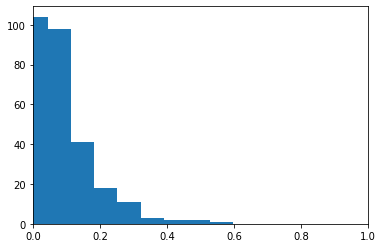

/home/ict520c/.virtualenvs/mp/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log


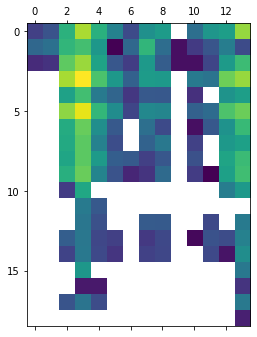

In [32]:
import sklearn.metrics

training_dataset = pp_train_dataset

expected_output = np.concatenate([*training_dataset.map(lambda X, y: tf.argmax(y, axis=-1)).as_numpy_iterator()])
input_length = np.concatenate([*training_dataset.map(lambda X, y: tf.argmin(tf.squeeze(X['mask']), axis=-1)).as_numpy_iterator()])

evaluation_result = transfer_learning.evaluate_model(model, training_dataset)

model_prediction = model.predict(training_dataset)
model_prediction = tf.math.argmax(model_prediction, axis=-1)

print('training dataset size:', training_dataset.unbatch().reduce(0, lambda a, b: a+1))
print('expected output', expected_output.shape, 'input_length', input_length.shape)

# input_length[] = length
# expected_output[batch#, t] = state_id
ari_scores = []
x_outputs = []
predictions = []
for _x_output, _prediction, l in zip(expected_output, model_prediction, input_length):
    x_output = _x_output[:l]
    prediction = _prediction[:l]

    x_outputs.append(x_output)
    predictions.append(prediction)

    ari = sklearn.metrics.adjusted_rand_score(x_output, prediction)
    ari_scores.append(ari)

predictions = tf.concat(predictions, axis=0).numpy()
x_outputs = tf.concat(x_outputs, axis=0).numpy()
ari_scores = np.array(ari_scores)
plt.hist(ari_scores)
plt.xlim([0, 1])
plt.show()

def create_mappings(predictions, expected_outputs):
    from sklearn.metrics.cluster import contingency_matrix

    expected_outputs_u, expected_outputs_idx = np.unique(expected_outputs, return_inverse=True)
    predictions_u, predictions_idx = np.unique(predictions, return_inverse=True)
    contingency = contingency_matrix(expected_outputs, predictions, sparse=False)
    # print('pred', len(predictions_u), predictions_u)
    # print('xout', len(expected_outputs_u), expected_outputs_u)
    # print('cont', contingency.shape, contingency)
    # print('argm', np.argmax(contingency, axis=1).shape, np.argmax(contingency, axis=1))
    plt.matshow(np.log(contingency))
    plt.show()
    mapping = {expected_outputs_u[i]: predictions_u[j] for i, j in enumerate(np.argmax(contingency, axis=1))}
    # print(mapping)
    return mapping

mapping = create_mappings(predictions, x_outputs)

2. make predictions and evaluate

In [49]:
from collections import defaultdict

results = dict()

model_path = Path('models/transfer_baselines/2/')
model_path.mkdir(parents=True, exist_ok=True)

def _map(inp_tensor):
    return tf.map_fn(lambda old: mapping.get(int(old), int(old)), inp_tensor)

def _clip(_):
    t, l = _
    # return tf.slice(t, 0, l)
    return t[:l]

# for i, X in enumerate([*range(5, 80, 5)]*10):
for i in tqdm.tqdm(range(10)):
    col_name = f'baseline_2__trial_{i}'
    training_dataset = pp_validation_dataset.shuffle(1600)

    expected_output = np.concatenate([*training_dataset.map(lambda X, y: tf.argmax(y, axis=-1)).as_numpy_iterator()])
    input_length = np.concatenate([*training_dataset.map(lambda X, y: tf.argmin(tf.squeeze(X['mask']), axis=-1)).as_numpy_iterator()])

    evaluation_result = transfer_learning.evaluate_model(
        model,
        training_dataset,
        transfer_learning.metrics_reporting[:-2]
    )

    # Classification prediction happens after applying the mapping
    model_prediction = tf.math.argmax(model.predict(training_dataset), axis=-1)
    for metric in transfer_learning.metrics_reporting[-2:]:
        evaluation_result[metric.name] = 0
    evaluation_results_dict = defaultdict(list)

    for x_output, prediction in zip(
                  map(_clip, zip(expected_output, input_length)),
        map(_map, map(_clip, zip(model_prediction, input_length))),
    ):
        x_output = tf.one_hot(tf.reshape(x_output, [1, -1]), depth=25)
        prediction = tf.one_hot(tf.reshape(prediction, [1, -1]), depth=25)
        for metric in transfer_learning.metrics_reporting[-2:]:
            metric.reset_states()
            metric.update_state(x_output, prediction)
            evaluation_results_dict[metric.name].append(metric.result())

    for metric in transfer_learning.metrics_reporting[-2:]:
        evaluation_result[metric.name] = np.mean(evaluation_results_dict[metric.name])
    evaluation_results_dict.clear()

    evaluation_result.rename(col_name, inplace=True)
    results[col_name] = evaluation_result

results_df = pd.DataFrame(results).T
results_df.to_csv(model_path / 'results.csv')
results_df.median().to_csv(model_path / 'results-median.csv')
results_df.mean().to_csv(model_path / 'results-mean.csv')

In [ ]:
ins, ground_truth = training_dataset
prediction = model.predict_on_batch(ins)

ground_truth = tf.squeeze(ground_truth)

for metric in metrics_reporting:
    metric.reset_states()
    metric.update_state(ground_truth, prediction)

prediction = tf.math.argmax(prediction, axis=-1)
prediction = tf.map_fn(lambda old: mapping[old], prediction)
no_clutter = tf.map_fn(remove_clutter_one_sample, prediction)
ground_truth = tf.math.argmax(ground_truth, axis=-1)

mask = tf.squeeze(ins['mask'], axis=-1)
run_length = tf.math.minimum(tf.argmin(mask, axis=-1), N)

max_run_length_in_batch = int(tf.math.reduce_max(run_length))

# results.append(
#     [set_name] + [float(metric.result()) for metric in metrics_reporting]
# )

for prednc, truth, idx in zip(no_clutter, ground_truth, run_length):
    truth, prednc = truth[:idx], prednc[:idx]

    concat = tf.stack((prednc, truth), axis=0)


In [ ]:
ins, ground_truth = training_dataset
prediction = model.predict_on_batch(ins)

ground_truth = tf.squeeze(ground_truth)

for metric in metrics_reporting:
    metric.reset_states()
    metric.update_state(ground_truth, prediction)

prediction = tf.math.argmax(prediction, axis=-1)
prediction = tf.map_fn(lambda old: mapping[old], prediction)
no_clutter = tf.map_fn(remove_clutter_one_sample, prediction)
ground_truth = tf.math.argmax(ground_truth, axis=-1)

mask = tf.squeeze(ins['mask'], axis=-1)
run_length = tf.math.minimum(tf.argmin(mask, axis=-1), N)

max_run_length_in_batch = int(tf.math.reduce_max(run_length))

# results.append(
#     [set_name] + [float(metric.result()) for metric in metrics_reporting]
# )

for prednc, truth, idx in zip(no_clutter, ground_truth, run_length):
    truth, prednc = truth[:idx], prednc[:idx]

    concat = tf.stack((prednc, truth), axis=0)


In [ ]:
ins, ground_truth = training_dataset
prediction = model.predict_on_batch(ins)

ground_truth = tf.squeeze(ground_truth)

for metric in metrics_reporting:
    metric.reset_states()
    metric.update_state(ground_truth, prediction)

prediction = tf.math.argmax(prediction, axis=-1)
prediction = tf.map_fn(lambda old: mapping[old], prediction)
no_clutter = tf.map_fn(remove_clutter_one_sample, prediction)
ground_truth = tf.math.argmax(ground_truth, axis=-1)

mask = tf.squeeze(ins['mask'], axis=-1)
run_length = tf.math.minimum(tf.argmin(mask, axis=-1), N)

max_run_length_in_batch = int(tf.math.reduce_max(run_length))

# results.append(
#     [set_name] + [float(metric.result()) for metric in metrics_reporting]
# )

for prednc, truth, idx in zip(no_clutter, ground_truth, run_length):
    truth, prednc = truth[:idx], prednc[:idx]

    concat = tf.stack((prednc, truth), axis=0)
